
# Presidential Speech comparison - 
## Assignment 1 - COSC 545 Fall 2022
## Dan Scott - dscott57 

1. Compare word frequencies between two works of a single author.
1. Compare word frequencies between works of two authors.
1. Are there some words preferred by one author but used less frequently by another author?

Extra credit

1. The frequency of a specific word, e.g., "would" should follow a binomial distribution (each regular word in a document is a trial and with probability p that word is "would". The estimate for p is N("would")/N(regular word)). Do these binomial distributions for your chosen word differ significantly between books of the same author or between authors? 


### This analysis compares presidential speeches from two presidents: Presidents Rosovelt and Obama. <br> Using text analysis techniques, the analysis will compare the term frequencies between various speeches of the president and between presidents. 


### Gathering the data

In each of the webpages, there exists an html 'DIV' tag which houses the text of the speech.  Using BeautifulSoup, we can extract the specific text by the html class attribute tag like this:
<code >
    soup.findAll('div', attrs={'class':'view-transcript'})
    # Or alternatly, just the first occurance of a div with that class
    soup.find('div', attrs={'class':'view-transcript'})
</code>
<br>


#### Using the millercenter website, we scape 8 specific speeches from two authors

In [1]:
baseURL = 'https://millercenter.org/the-presidency/presidential-speeches/'

speech_urls = \
[('Rosovelt_1', 'view-transcript', 'december-3-1901-first-annual-message'),
 ('Rosovelt_2', 'view-transcript', 'december-2-1902-second-annual-message'),
 ('Rosovelt_3', 'view-transcript', 'december-7-1903-third-annual-message'),
 ('Rosovelt_4', 'view-transcript', 'december-6-1904-fourth-annual-message'),
 ('Obama_1', 'transcript-inner', 'january-27-2010-2010-state-union-address'),
 ('Obama_2', 'transcript-inner', 'january-25-2011-2011-state-union-address'),
 ('Obama_3', 'transcript-inner', 'january-24-2012-2012-state-union-address'),
 ('Obama_4', 'transcript-inner', 'february-13-2013-2013-state-union-address')
 ]



In [2]:
# Function: get_transcript()
# Extract the text of the HTML by finding a specific HTML tag
# Requres html formatted text and a class tag
def get_transcript(html, tag):
    if not len(tag) and not len(html):
        raise RuntimeError('the html tag cannot be empty')
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    transcript = soup.find('div', attrs={'class': tag})
    return BeautifulSoup.get_text(transcript)

import requests

# All the speeches are stored in 'text' format,
# by passing the URL to BeautifulSoup, and removing the HTML markup,
# the raw text is returned and stored in a list
raw_transcripts = []

for pres, htmlTag, speechUrl in speech_urls:
    r = requests.get(baseURL + speechUrl)
    raw_transcripts.append(get_transcript(r.text, htmlTag))

    

### Cleaning The Data
While most of the text has been washed of HTML tags, there are still non-language characters and such that need to be cleaned. We also convert the speech to lower case and remove the word 'Transcript' which comes from the HTML page's title.

Later, during the exploring, the stop words are also removed

In [3]:
# For example, looking at the first 100 characters of the 
# last speech, there are control characters (\r\n) as well as 
# unrecognizable characters (\xa0)
raw_transcripts[4][0:100]

'\nTranscript\nMadam Speaker, Vice President Biden, Members of Congress, distinguished guests, and fell'

In [4]:
import re
import pandas as pd

def raw_to_df(index, text, url, pres):
    text = re.sub(r'\W',' ', text)    #remove all non-AlphaNumeric characters
    text = re.sub(r'Transcript','',text) #remove the word 'Transcript' which is from the header
    data = {'president':pres, 'url':url, 'speech':text}
    return data

frames = []
for i in range(len(raw_transcripts)):
    frames.append( ( raw_to_df(i, raw_transcripts[i], speech_urls[i][2], speech_urls[i][0])) )

          

In [5]:
df1 = pd.DataFrame.from_dict(frames, orient='columns',)
df1.reset_index(inplace=True, drop=True)
df1.head(10)


president                                        url  \
0  Rosovelt_1       december-3-1901-first-annual-message   
1  Rosovelt_2      december-2-1902-second-annual-message   
2  Rosovelt_3       december-7-1903-third-annual-message   
3  Rosovelt_4      december-6-1904-fourth-annual-message   
4     Obama_1   january-27-2010-2010-state-union-address   
5     Obama_2   january-25-2011-2011-state-union-address   
6     Obama_3   january-24-2012-2012-state-union-address   
7     Obama_4  february-13-2013-2013-state-union-address   

                                              speech  
0  To the Senate and House of Representatives  Th...  
1  To the Senate and House of Representatives  We...  
2  To the Senate and House of Representatives  Th...  
3  To the Senate and House of Representatives  Th...  
4    Madam Speaker  Vice President Biden  Members...  
5    Mr  Speaker  Mr  Vice President  members of ...  
6     Mr  Speaker  Mr  Vice President  members of...  
7      Mr  Speaker  Mr  Vice President  members o...

### Explore Data and add some features
Here we attempt to draw simple data analytics from each speech.  
-- The analysis converts all text to lower,  removes stop words, change 
-- put's it all in a pandas.DataFrame to keep it organized.

In [6]:
# The speeches are in the speech column, 
# just looking around here at some of the data to get a feel 
# for what's there.  added the elipisis to remind me there's more
df1.speech[4][0:1000]+' ...'

'  Madam Speaker  Vice President Biden  Members of Congress  distinguished guests  and fellow Americans  Our Constitution declares that from time to time  the President shall give to Congress information about the state of our Union  For 220 years  our leaders have fulfilled this duty  They ve done so during periods of prosperity and tranquility  and they ve done so in the midst of war and depression  at moments of great strife and great struggle  It s tempting to look back on these moments and assume that our progress was inevitable  that America was always destined to succeed  But when the Union was turned back at Bull Run and the Allies first landed at Omaha Beach  victory was very much in doubt  When the market crashed on Black Tuesday and civil rights marchers were beaten on Bloody Sunday  the future was anything but certain  These were the times that tested the courage of our convictions and the strength of our Union  And despite all our divisions and disagreements  our hesitatio

#### Continuing to clean up the speech's text, we make all words lower case, 'Tokenize' the speech into a list of words, and remove the stop words.

NOTE: After the first analysis, It became apparent that the word 'Applause' was add to the transcripts.  As that was not part of the speech, I added it to the stop words.

In [7]:
from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
import nltk
stop_words = nltk.corpus.stopwords.words('english')+['applause']

def remove_stop_words(tokenized_text):
    filtered_sent=[]
    for w in tokenized_text:
        if w not in stop_words:
            filtered_sent.append(w)
    return filtered_sent


df1['tokenized_words'] = df1.speech.apply(str.lower)
df1['tokenized_words'] = df1.tokenized_words.apply(word_tokenize)
df1['tokenized_words'] = df1.tokenized_words.apply(remove_stop_words)
df1['number_of_words'] = df1.tokenized_words.apply(len)  #this is the number of words AFTER removing stop words

df1.head()

president                                       url  \
0  Rosovelt_1      december-3-1901-first-annual-message   
1  Rosovelt_2     december-2-1902-second-annual-message   
2  Rosovelt_3      december-7-1903-third-annual-message   
3  Rosovelt_4     december-6-1904-fourth-annual-message   
4     Obama_1  january-27-2010-2010-state-union-address   

                                              speech  \
0  To the Senate and House of Representatives  Th...   
1  To the Senate and House of Representatives  We...   
2  To the Senate and House of Representatives  Th...   
3  To the Senate and House of Representatives  Th...   
4    Madam Speaker  Vice President Biden  Members...   

                                     tokenized_words  number_of_words  
0  [senate, house, representatives, congress, ass...             9535  
1  [senate, house, representatives, still, contin...             4709  
2  [senate, house, representatives, country, cong...             7603  
3  [senate, house, representatives, nation, conti...             8582  
4  [madam, speaker, vice, president, biden, membe...             3678

In [8]:
from collections import Counter
import operator

#This is basicaly the word frequency counter from Dr. Mockus
def calcWordFrequency(text):
    wf = Counter(text)   
    # Get an ordered list
    wfs = sorted(wf.items(), key = operator.itemgetter(1), reverse=True)
    # only use the top twenty words
    ml = min(len(wfs),20)
    return (wfs[0:ml][::-1])

#Just checking it works and what the output shall be
calcWordFrequency(df1.tokenized_words[6])
    

[('time', 16),
 ('work', 17),
 ('let', 18),
 ('country', 18),
 ('years', 18),
 ('like', 19),
 ('year', 20),
 ('world', 20),
 ('americans', 20),
 ('tax', 23),
 ('every', 23),
 ('energy', 23),
 ('people', 23),
 ('one', 24),
 ('get', 25),
 ('right', 27),
 ('new', 27),
 ('america', 33),
 ('jobs', 34),
 ('american', 35)]

In [9]:
#Plot the results: are there striking differences in language?
import numpy as np
import pylab
import matplotlib.pyplot as plt

%matplotlib inline
def plotTwoLists (wf_ee, wf_bu, title):
    f = plt.figure (figsize=(10, 6))
    # this is painfully tedious....
    f .suptitle (title, fontsize=20)
    ax = f.add_subplot(111)
    ax .spines ['top'] .set_color ('none')
    ax .spines ['bottom'] .set_color ('none')
    ax .spines ['left'] .set_color ('none')
    ax .spines ['right'] .set_color ('none')
    ax .tick_params (labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=20)

    # Create two subplots, this is the first one
    ax1 = f .add_subplot (121)
    plt .subplots_adjust (wspace=.5)

    pos = np .arange (len(wf_ee)) 
    ax1 .tick_params (axis='both', which='major', labelsize=14)
    pylab .yticks (pos, [ x [0] for x in wf_ee ])
    ax1 .barh (range(len(wf_ee)), [ x [1] for x in wf_ee ], align='center')

    ax2 = f .add_subplot (122)
    ax2 .tick_params (axis='both', which='major', labelsize=14)
    pos = np .arange (len(wf_bu)) 
    pylab .yticks (pos, [ x [0] for x in wf_bu ])
    ax2 .barh (range (len(wf_bu)), [ x [1] for x in wf_bu ], align='center')

 

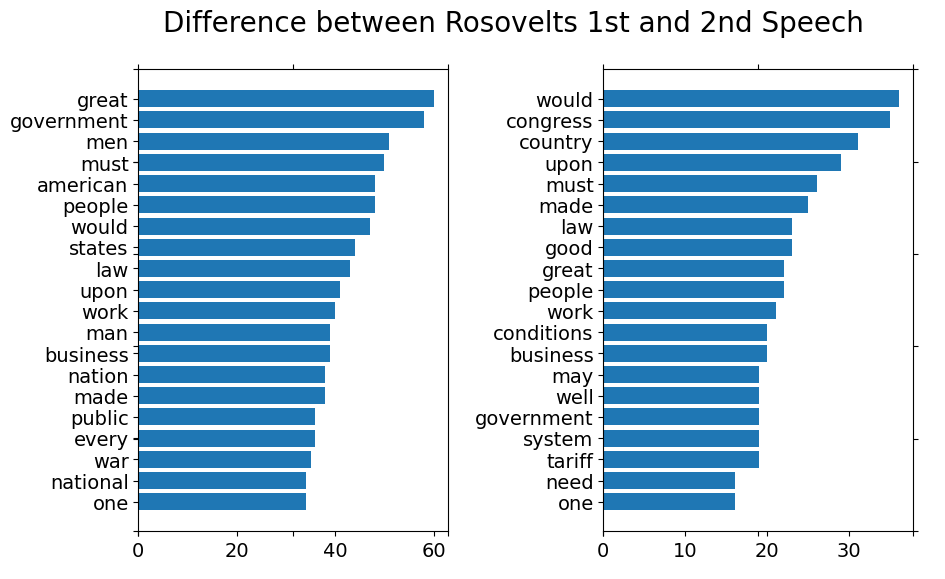

In [10]:
wf_Rosovelt1 = calcWordFrequency(df1.tokenized_words[0])    
wf_Rosovelt2 = calcWordFrequency(df1.tokenized_words[1])    
    
plotTwoLists(wf_Rosovelt1, wf_Rosovelt2, 'Difference between Rosovelts 1st and 2nd Speech')

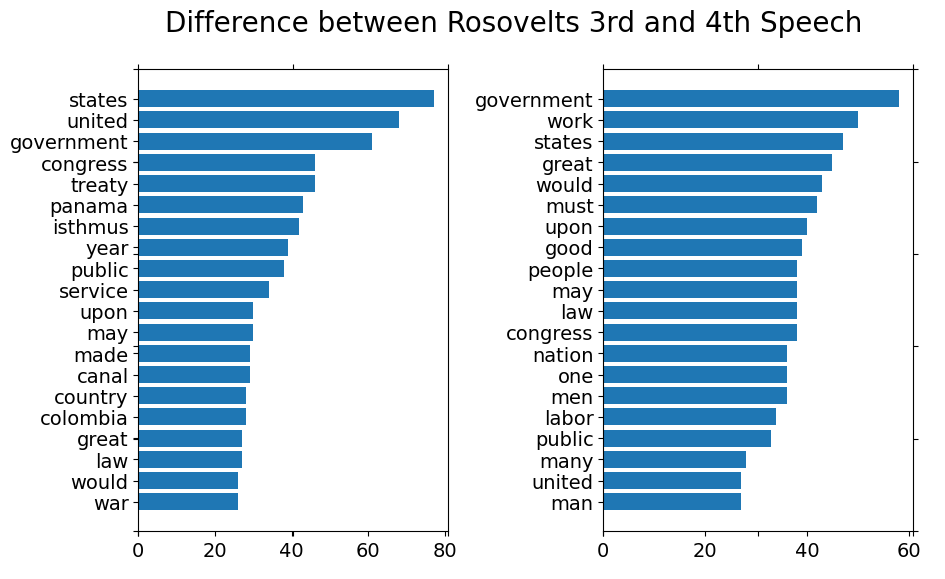

In [11]:
wf_Rosovelt3 = calcWordFrequency(df1.tokenized_words[2])    
wf_Rosovelt4 = calcWordFrequency(df1.tokenized_words[3])    
    
plotTwoLists(wf_Rosovelt3, wf_Rosovelt4, 'Difference between Rosovelts 3rd and 4th Speech')

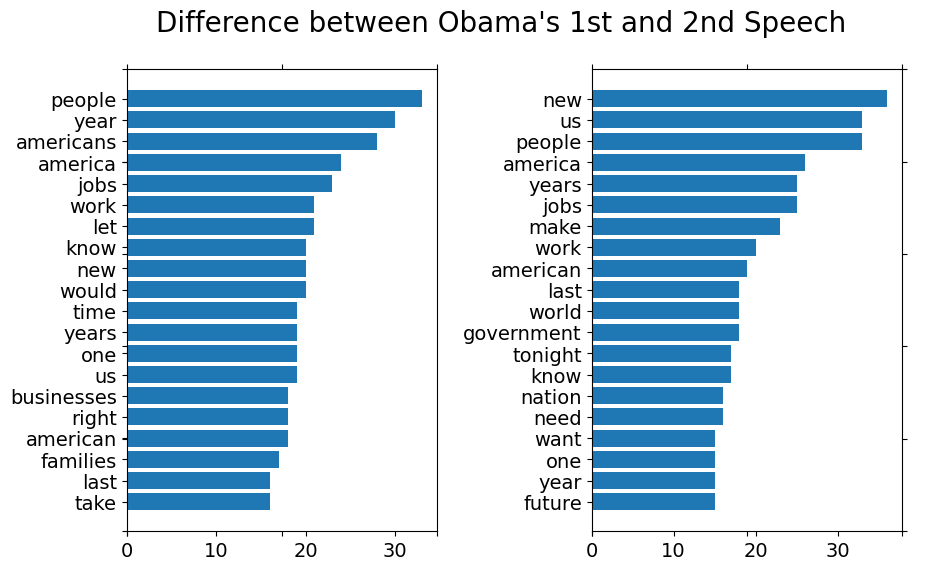

In [12]:
wf_Obama1 = calcWordFrequency(df1.tokenized_words[4])    
wf_Obama2 = calcWordFrequency(df1.tokenized_words[5])    
    
plotTwoLists(wf_Obama1, wf_Obama2, 'Difference between Obama\'s 1st and 2nd Speech')

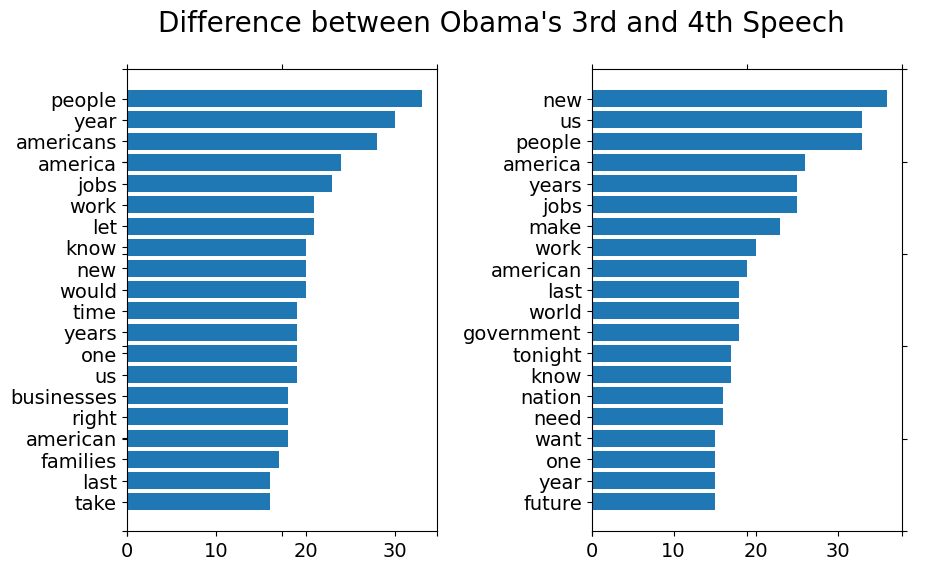

In [13]:
wf_Obama3 = calcWordFrequency(df1.tokenized_words[6])    
wf_Obama4 = calcWordFrequency(df1.tokenized_words[7])    
    
plotTwoLists(wf_Obama1, wf_Obama2, 'Difference between Obama\'s 3rd and 4th Speech')

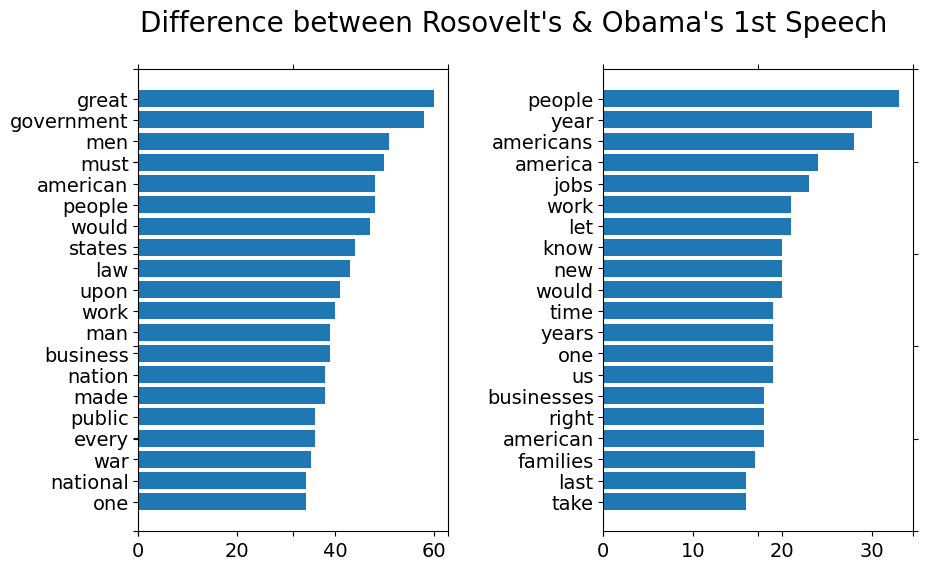

In [14]:
plotTwoLists(wf_Rosovelt1, wf_Obama1, 'Difference between Rosovelt\'s & Obama\'s 1st Speech')

### Comparing TF between Rosovelt & Obama

The following barchart depicts the top 20 Term Frequencies (TFs) of the first four annual speeches combined.  All the terms from Rosovelt's speeches were calcualted as one corpus, as were Obama's speeches. There are some TFs that rank high in both sets { people, work, one} and there are many TFs that do not occur in the opposite set {In R not in O='government'; In O not in R='america'}


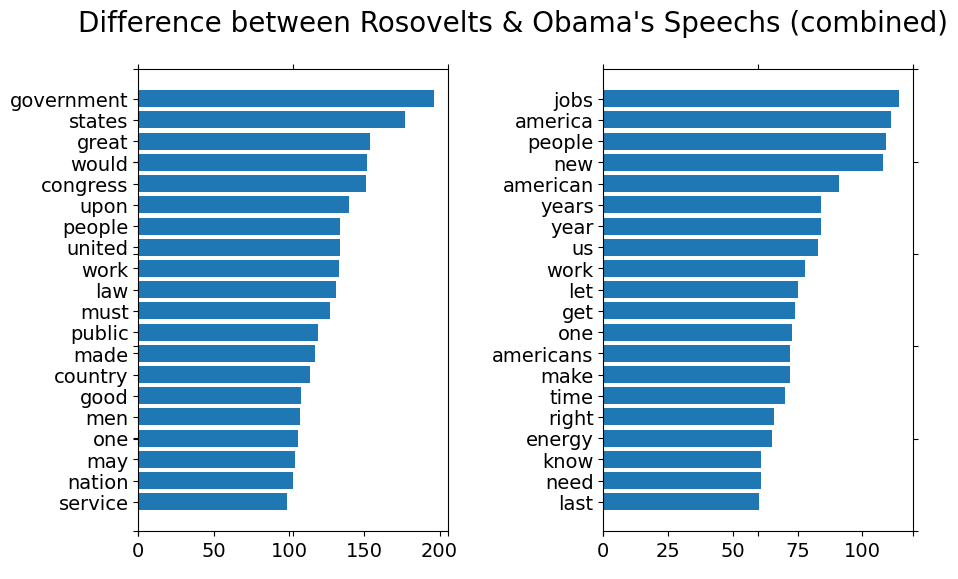

In [15]:
wf_All_Rosovelt = calcWordFrequency(df1.tokenized_words[0]+df1.tokenized_words[1]+df1.tokenized_words[2]+df1.tokenized_words[3])    
wf_All_Obama = calcWordFrequency(df1.tokenized_words[4]+df1.tokenized_words[5]+df1.tokenized_words[6]+df1.tokenized_words[7])    

plotTwoLists(wf_All_Rosovelt, wf_All_Obama, 'Difference between Rosovelts & Obama\'s Speechs (combined)')


#### These are the top 20 TFs in common between all Rosovelt's and Obama's speeches.

In [16]:
#These are the top 20 TFs in common between Rosovelt's and Obama's speeches.
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

intersection([num[0] for num in wf_All_Rosovelt], [num[0] for num in wf_All_Obama])


['one', 'work', 'people']

#### These are the top 20 TFs from Obama's speeches that are not in the top 20 TFs in Rosovelts speeches

In [17]:
#These are the top 20 TFs from Obama's speeches that are not in the top 20 TFs in Rosovelts speeches
print(set([num[0] for num in wf_All_Obama]).difference(set([num[0] for num in wf_All_Rosovelt])))

{'energy', 'america', 'right', 'know', 'make', 'us', 'new', 'americans', 'get', 'let', 'years', 'time', 'year', 'american', 'last', 'jobs', 'need'}


#### These are the top 20 TFs from Rosovelt's speeches that are not in the top 20 TFs in Obama's speeches

In [18]:
#These are the top 20 TFs from Rosovelt's speeches that are not in the top 20 TFs in Obama's speeches
print(set([num[0] for num in wf_All_Rosovelt]).difference(set([num[0] for num in wf_All_Obama])))

{'law', 'may', 'congress', 'service', 'men', 'states', 'good', 'must', 'would', 'united', 'public', 'great', 'country', 'upon', 'nation', 'made', 'government'}


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#instantiate CountVectorizer() 
cv=CountVectorizer(stop_words = stop_words, min_df = 1) 

# this step generates word counts for all the words in all the speeches
word_count_vector=cv.fit_transform(df1.speech)


In [20]:
#These are all the words that are counted in the CountVectorizer for all speeches (every word in every speech)
X = word_count_vector.toarray()

#THis matrix combined with the cv.feature names above, tells us how many words are in each document
# for example, the '00' and '000' words occur 1 and 5 times respectively in the last document. 
bagofwords=pd.DataFrame(X, columns = cv.get_feature_names_out())
bagofwords.head(10)

00  000  007  009  024  040  047  067  099  10  ...  younger  youngest  \
0   0    2    0    1    0    0    0    0    0   0  ...        1         0   
1   0    0    0    0    0    0    1    1    0   2  ...        0         0   
2   0    5    1    0    1    1    0    0    1   0  ...        0         0   
3   0    2    0    0    0    0    0    0    0   1  ...        0         0   
4   0    3    0    0    0    0    0    0    0   5  ...        0         0   
5   0    8    0    0    0    0    0    0    0   3  ...        0         0   
6   0    7    0    0    0    0    0    0    0   2  ...        0         0   
7   1    5    0    0    0    0    0    0    0   3  ...        0         1   

   youngstown  youth  youthful  yukon  zeal  zealous  zone  zoological  
0           0      0         1      0     2        0     0           1  
1           0      0         0      0     0        0     0           0  
2           0      0         0      0     0        0     3           0  
3           0      1         0      1     0        1     2           0  
4           0      0         0      0     0        0     0           0  
5           0      0         0      0     0        0     0           0  
6           0      0         0      0     0        0     0           0  
7           1      0         0      0     0        0     0           0  

[8 rows x 7667 columns]

#### Word cloud of words (TF is size of word) from all Rosovelt and Obama speeches combined

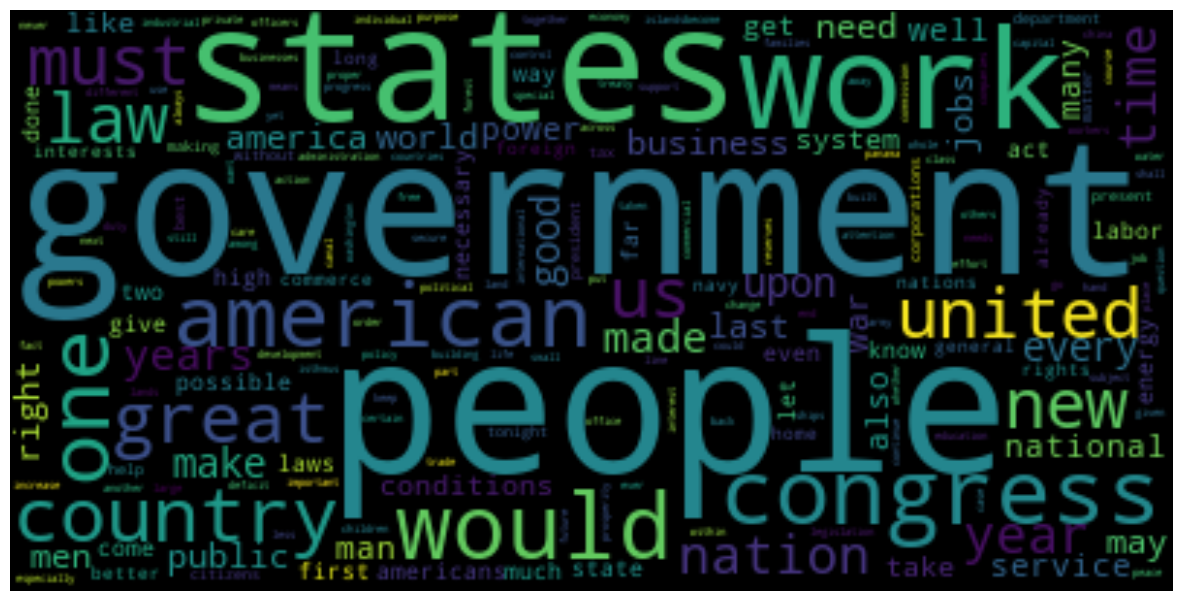

In [21]:
docs = X[(X>1).any(axis=1)]
words = np.array(cv.get_feature_names_out())

doc = docs[:].sum(axis=0)
idx = (docs[:].sum(axis=0)>3)  #only get the words that occur more than 3 times
doc_words = words[idx]
doc_counts = doc[doc>3]


frequencies = dict(zip(doc_words, doc_counts))
frequencies

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black').fit_words(frequencies)
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(wordcloud, interpolation='bilinear')
_ = ax.axis("off")

#### Word Cloud of all Rosovelt Speeches

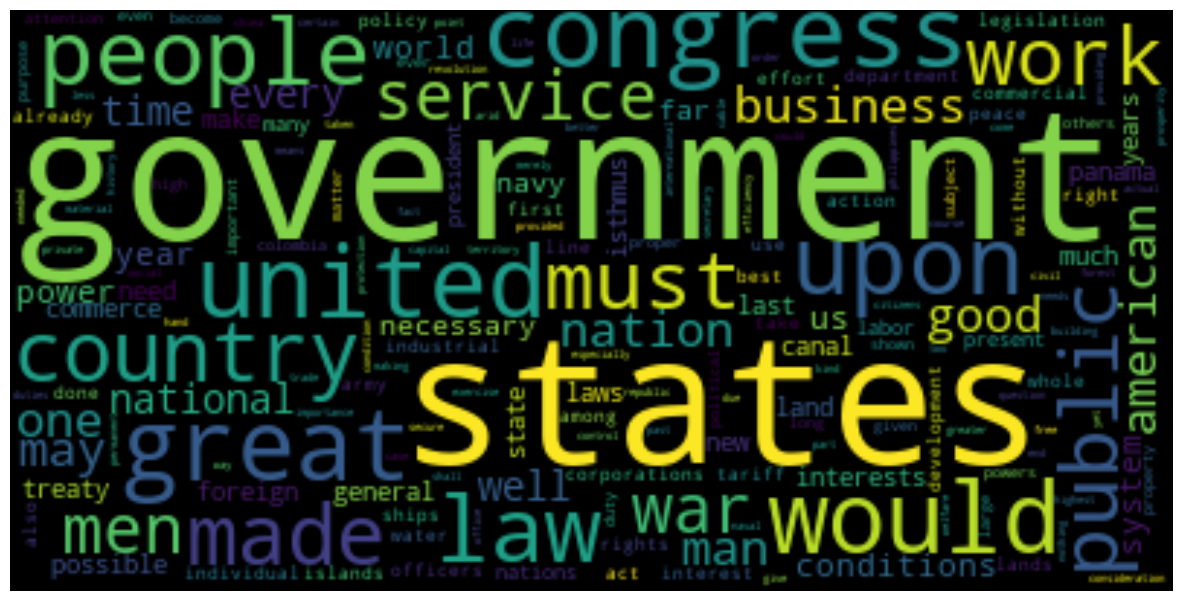

In [22]:
docs = X[(X>1).any(axis=1)]
words = np.array(cv.get_feature_names_out())

doc = docs[0:3].sum(axis=0)
idx = (docs[0:3].sum(axis=0)>3)  #only get the words that occur more than 3 times
doc_words = words[idx]
doc_counts = doc[doc>3]


frequencies = dict(zip(doc_words, doc_counts))
frequencies

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black').fit_words(frequencies)
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(wordcloud, interpolation='bilinear')
_ = ax.axis("off")

#### Word Cloud of all Obama Speeches

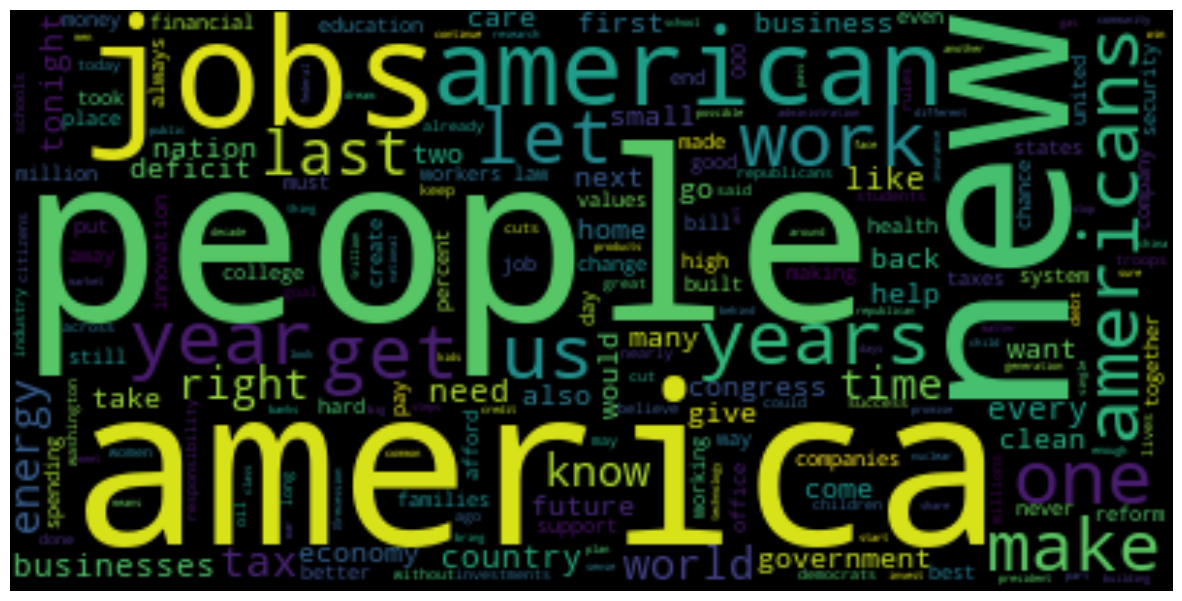

In [23]:
docs = X[(X>1).any(axis=1)]
words = np.array(cv.get_feature_names_out())

doc = docs[4:7].sum(axis=0)
idx = (docs[4:7].sum(axis=0)>3)  #only get the words that occur more than 3 times
doc_words = words[idx]
doc_counts = doc[doc>3]


frequencies = dict(zip(doc_words, doc_counts))
frequencies

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black').fit_words(frequencies)
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(wordcloud, interpolation='bilinear')
_ = ax.axis("off")

### Comparing TF-IDF of all speeches combined

In [24]:
# settings that you use for count vectorizer go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True, stop_words=stop_words)

# use all documents 
fitted_vectorizer=tfidf_vectorizer.fit(df1.speech)
tfidf_vectorizer_vectors=fitted_vectorizer.transform(df1.speech)


In [25]:
#These are all the words that are counted in the TfidfVectorizer for all speeches (every word in every speech)
Z = tfidf_vectorizer_vectors.toarray()

#THis matrix combined with the cv.feature names above, tells us how many words are in each document
# for example, the '00' and '000' words occur 1 and 5 times respectively in the last document. 
bagofwordsTFIDF=pd.DataFrame(Z, columns = fitted_vectorizer.get_feature_names_out())
bagofwordsTFIDF.head(10)

00       000       007       009       024       040      047  \
0  0.00000  0.005698  0.000000  0.006383  0.000000  0.000000  0.00000   
1  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.01162   
2  0.00000  0.015729  0.007047  0.000000  0.007047  0.007047  0.00000   
3  0.00000  0.006313  0.000000  0.000000  0.000000  0.000000  0.00000   
4  0.00000  0.017871  0.000000  0.000000  0.000000  0.000000  0.00000   
5  0.00000  0.049944  0.000000  0.000000  0.000000  0.000000  0.00000   
6  0.00000  0.040942  0.000000  0.000000  0.000000  0.000000  0.00000   
7  0.01342  0.029953  0.000000  0.000000  0.000000  0.000000  0.00000   

       067       099        10  ...   younger  youngest  youngstown     youth  \
0  0.00000  0.000000  0.000000  ...  0.006383   0.00000     0.00000  0.000000   
1  0.01162  0.000000  0.011613  ...  0.000000   0.00000     0.00000  0.000000   
2  0.00000  0.007047  0.000000  ...  0.000000   0.00000     0.00000  0.000000   
3  0.00000  0.000000  0.003533  ...  0.000000   0.00000     0.00000  0.007071   
4  0.00000  0.000000  0.033343  ...  0.000000   0.00000     0.00000  0.000000   
5  0.00000  0.000000  0.020967  ...  0.000000   0.00000     0.00000  0.000000   
6  0.00000  0.000000  0.013095  ...  0.000000   0.00000     0.00000  0.000000   
7  0.00000  0.000000  0.020118  ...  0.000000   0.01342     0.01342  0.000000   

   youthful     yukon      zeal   zealous      zone  zoological  
0  0.006383  0.000000  0.012765  0.000000  0.000000    0.006383  
1  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000  
2  0.000000  0.000000  0.000000  0.000000  0.017719    0.000000  
3  0.000000  0.007071  0.000000  0.007071  0.011852    0.000000  
4  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000  
5  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000  
6  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000  
7  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000  

[8 rows x 7667 columns]

##### Word Cloud of the highest TF-IDF from all speeches

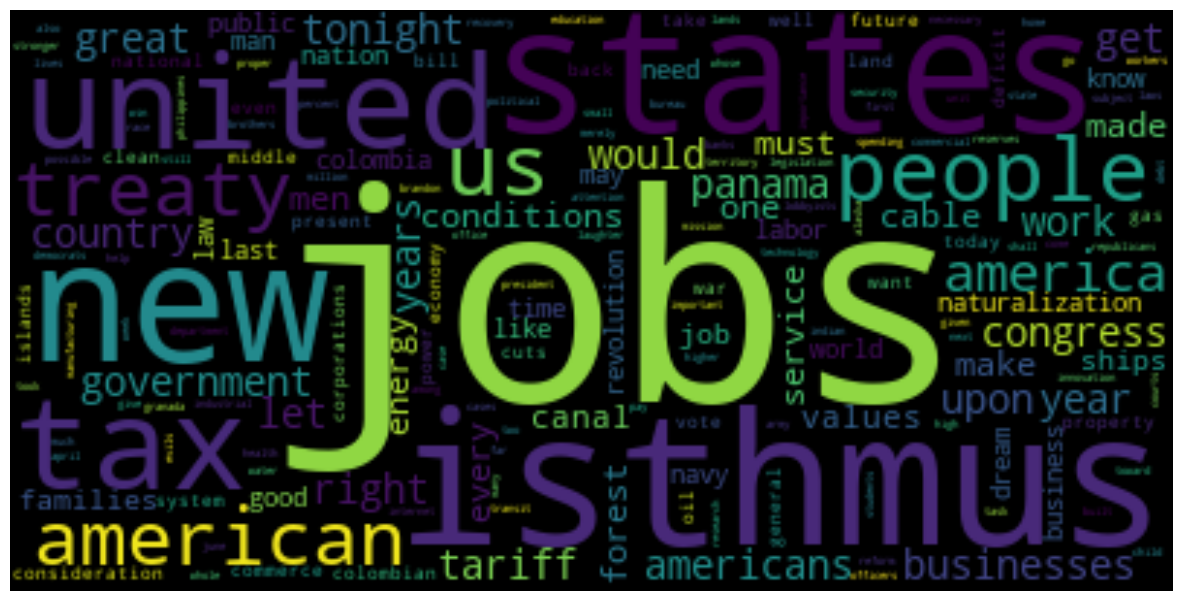

In [26]:
docs = Z[(Z>0).any(axis=1)]
words = np.array(fitted_vectorizer.get_feature_names_out())

doc = docs[:].max(axis=0)
idx = (docs[:].max(axis=0)>0)  #only get the words that have the higest(max) TFIDF
doc_words = words[idx]
doc_counts = doc[doc>0]


frequencies = dict(zip(doc_words, doc_counts))
frequencies

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black').fit_words(frequencies)
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(wordcloud, interpolation='bilinear')
_ = ax.axis("off")

### Comparing TF-IDF within Rosovelt's speeches

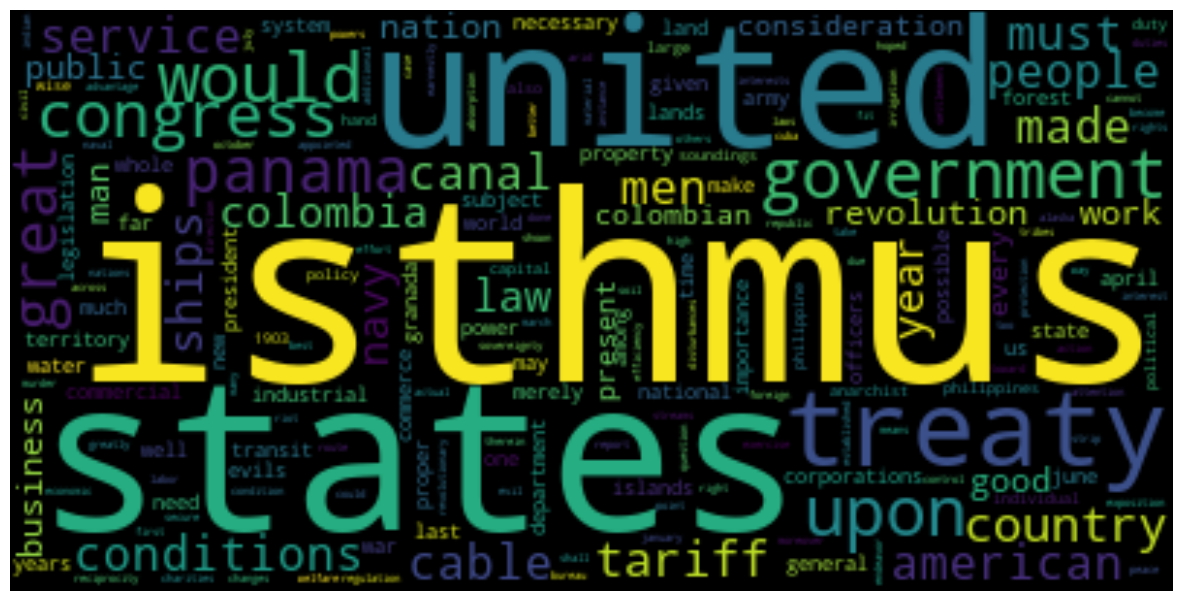

In [27]:
docs = Z[(Z>0).any(axis=1)]
words = np.array(fitted_vectorizer.get_feature_names_out())

doc = docs[0:3].max(axis=0)
idx = (docs[0:3].max(axis=0)>0)  #only get the words that have the higest(max) TFIDF
doc_words = words[idx]
doc_counts = doc[doc>0]


frequencies = dict(zip(doc_words, doc_counts))
frequencies

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black').fit_words(frequencies)
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(wordcloud, interpolation='bilinear')
_ = ax.axis("off")

### Comparing TFIDF between Obama's speeches

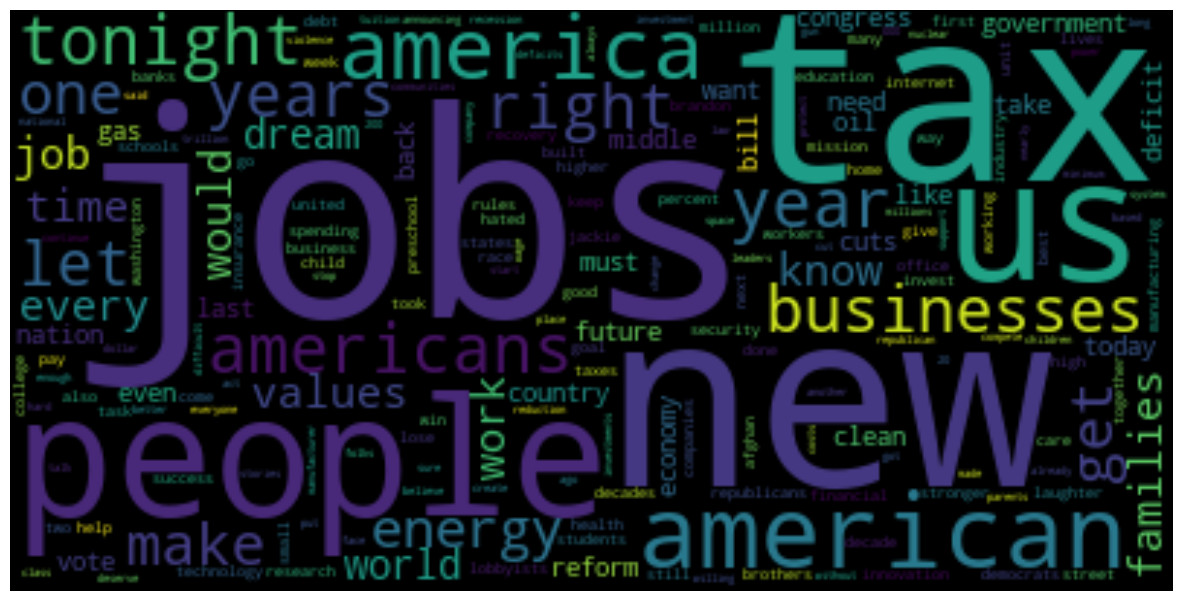

In [28]:
docs = Z[(Z>0).any(axis=1)]
words = np.array(fitted_vectorizer.get_feature_names_out())

doc = docs[4:].max(axis=0)
idx = (docs[4:].max(axis=0)>0)  #only get the words that have the higest(max) TFIDF
doc_words = words[idx]
doc_counts = doc[doc>0]


frequencies = dict(zip(doc_words, doc_counts))
frequencies

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black').fit_words(frequencies)
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(wordcloud, interpolation='bilinear')
_ = ax.axis("off")

### Slope Chart of high frequency words

In [216]:
bagofwords.loc[0:3, 'Author'] = 'Rosovelt'
bagofwords.loc[4:, 'Author'] = 'Obama'
ss = bagofwords.groupby('Author',as_index=True).sum()

wl = [num[0] for num in wf_All_Rosovelt]+[num[0] for num in wf_All_Obama]
df2 = ss.loc[:,wl].T
df2.head()

Author   Obama  Rosovelt
service      4        99
nation      45       103
may         16       104
one         73       106
men         15       107

<AxesSubplot:xlabel='Author'>

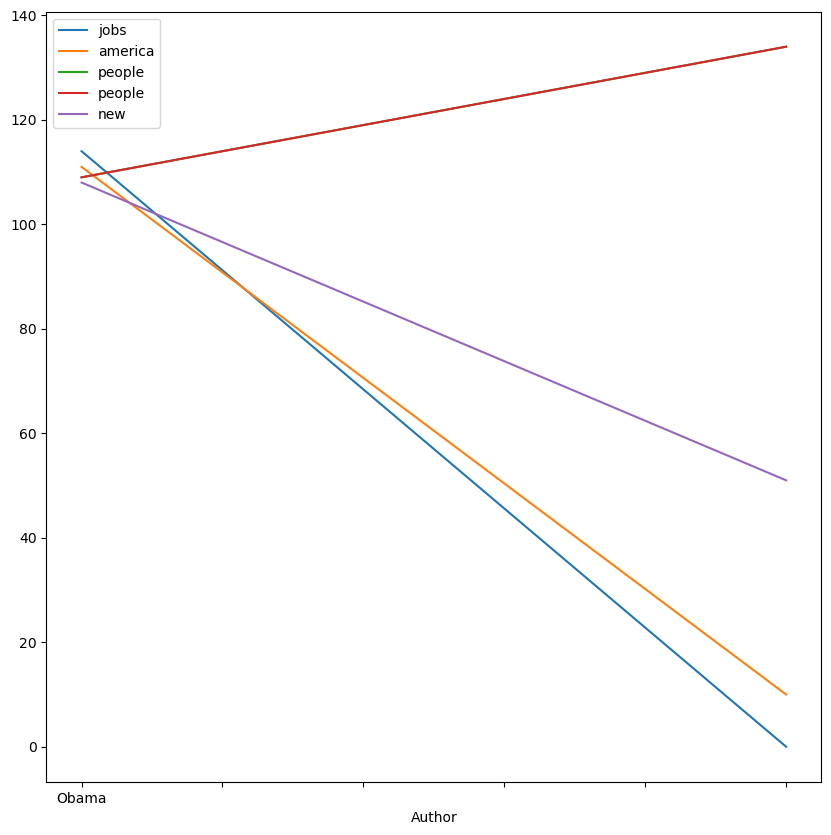

In [223]:
df2.sort_values(by='Obama',axis=0,ascending=False, inplace=True)
df2[0:5].T.plot(figsize=(10,10))


<AxesSubplot:xlabel='Author'>

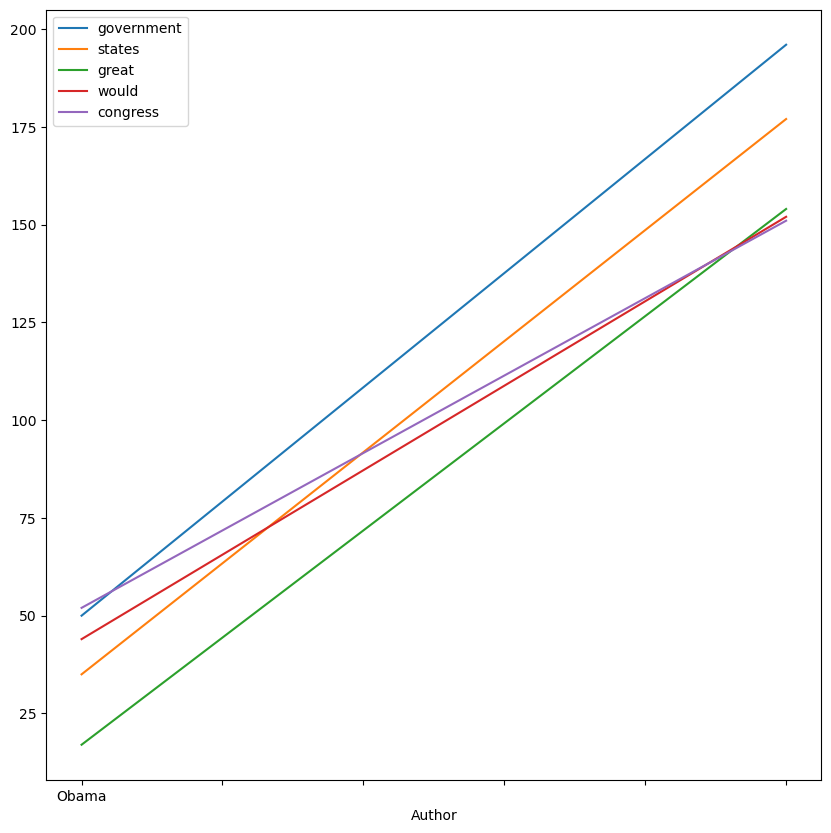

In [224]:
df2.sort_values(by='Rosovelt',axis=0,ascending=False, inplace=True)
df2[0:5].T.plot(figsize=(10,10))
plt.title()
plt.show()

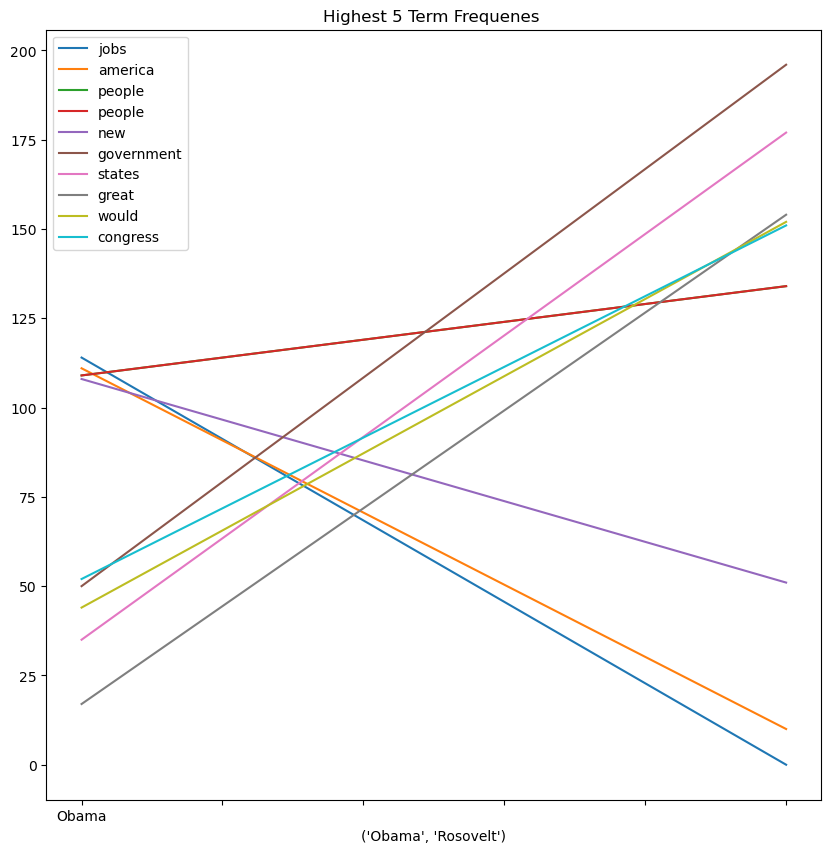

In [230]:
df2.sort_values(by='Obama',axis=0,ascending=False, inplace=True)
O = df2[0:5]
df2.sort_values(by='Rosovelt',axis=0,ascending=False, inplace=True)
R = df2[0:5]
OR = pd.concat([O,R])
OR.T.plot(figsize=(10,10))
plt.xlabel(('Obama','Rosovelt'))
plt.title('Highest 5 Term Frequenes ')
plt.show()

# BIBLIOGRAPY


https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

https://www.kaggle.com/code/ervishvanathmetkari/sentiment-analysis-movie-reviews

https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YxyTmHbMI_w

Top 'n' words from corpus
https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d

Word Cloud
https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5
https://github.com/rachelrakov/Intro_to_Machine_Learning/blob/master/sections/word_cloud.md
